### EM solver on two patches of the cubed sphere

Patch I will be called A and patch II will be called B to avoid confusion

In [1]:
import numpy as N
import matplotlib.pyplot as P
import matplotlib
import time
import gc
import scipy.integrate as spi
from skimage.measure import find_contours

from math import *

import sys
from figure_module import *

In [2]:
# Parameters
r = 1.0
cfl = 0.2

Nxi = 80
Neta = 80
NG = 1 # Number of ghosts zones
xi_min, xi_max = - N.pi / 4.0, N.pi / 4.0
eta_min, eta_max = - N.pi / 4.0, N.pi / 4.0
dxi = (xi_max - xi_min) / Nxi
deta = (eta_max - eta_min) / Neta

xi  = N.arange(- NG - int(Nxi / 2), NG + int(Nxi / 2), 1) * dxi
eta = N.arange(- NG - int(Neta / 2), NG + int(Neta / 2), 1) * deta

# xi  = N.linspace(xi_min - NG * dxi, xi_max + NG * dxi, Nxi + 2 * NG)
# eta = N.linspace(eta_min - NG * deta, eta_max + NG * deta, Neta + 2 * NG)

eta_grid, xi_grid = N.meshgrid(eta, xi)

xi_yee  = xi  + 0.5 * dxi
eta_yee = eta + 0.5 * deta

# Initialize fields
Er_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Br_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

E1d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

# Er0_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# E1u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# E2u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# Br0_a  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# B1u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# B2u0_a = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

Er_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Br_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

E1d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

# Er0_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# E1u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# E2u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# Br0_b  = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# B1u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
# B2u0_b = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

E2u_edge_a = N.zeros(Neta + 2 * NG)
E1u_edge_b = N.zeros(Neta + 2 * NG)
B1u_edge_a = N.zeros(Neta + 2 * NG)
B2u_edge_b = N.zeros(Neta + 2 * NG)

E1d_edge_b = N.zeros(Neta + 2 * NG)
B1d_edge_a = N.zeros(Neta + 2 * NG)

divB = N.zeros((2 * Nxi + 2 * NG, Neta + 2 * NG))
Ar = N.zeros((2 * Nxi + 2 * NG, Neta + 2 * NG))

In [3]:
# Metric tensor
g11d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g12d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g22d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        # 0 at (i, j)
        X = N.tan(xi[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 0] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 0] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 0] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 1 at (i + 1/2, j)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 1] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 1] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 1] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 2 at (i, j + 1/2)
        X = N.tan(xi[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 2] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 2] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 2] = - r * r * X * Y * C * C * D * D / (delta)**4

        # 3 at (i + 1/2, j + 1/2)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 3] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 3] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 3] = - r * r * X * Y * C * C * D * D / (delta)**4

sqrt_det_g = N.sqrt(g11d * g22d - g12d * g12d)
# g11u = g11d / (sqrt_det_g * sqrt_det_g)
# g22u = g22d / (sqrt_det_g * sqrt_det_g)
# g12u = - g12d / (sqrt_det_g * sqrt_det_g)

dt = cfl * N.min(1.0 / N.sqrt(g11d / (sqrt_det_g * sqrt_det_g) / (dxi * dxi) + g22d / (sqrt_det_g * sqrt_det_g) / (deta * deta) ))
print("delta t = {}".format(dt))

delta t = 0.0022369831595196996


In [4]:
def contra_to_cov_E_a():
    
    i0, i1 = NG, Nxi + NG - 1
    j0, j1 = NG, Neta + NG
             
    # E1d_a[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 1] * E1u_a[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 1] * (E2u_a[i0:i1, j0:j1] + N.roll(N.roll(E2u_a, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])
    # E2d_a[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 2] * E2u_a[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 2] * (E1u_a[i0:i1, j0:j1] + N.roll(N.roll(E1u_a, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1])

    E1d_a[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 1] * E1u_a[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 1] * \
                         (E2u_a[i0:i1, j0:j1] + N.roll(E2u_a, -1, axis = 0)[i0:i1, j0:j1] \
                        + N.roll(E2u_a, 1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(E2u_a, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])
    
    E2d_a[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 2] * E2u_a[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 2] * \
                         (E1u_a[i0:i1, j0:j1] + N.roll(E1u_a, 1, axis = 0)[i0:i1, j0:j1] \
                        + N.roll(E1u_a, -1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(E1u_a, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1])

def contra_to_cov_E_b():

    i0, i1 = NG + 1, Nxi + NG
    j0, j1 = NG, Neta + NG
            
    # E1d_b[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 1] * E1u_b[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 1] * (E2u_b[i0:i1, j0:j1] + N.roll(N.roll(E2u_b, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])
    # E2d_b[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 2] * E2u_b[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 2] * (E1u_b[i0:i1, j0:j1] + N.roll(N.roll(E1u_b, 1, axis = 1), -1, axis = 1)[i0:i1, j0:j1])

    E1d_b[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 1] * E1u_b[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 1] * \
                         (E2u_b[i0:i1, j0:j1] + N.roll(E2u_b, -1, axis = 0)[i0:i1, j0:j1] \
                        + N.roll(E2u_b, 1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(E2u_b, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])
    
    E2d_b[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 2] * E2u_b[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 2] * \
                         (E1u_b[i0:i1, j0:j1] + N.roll(E1u_b, 1, axis = 0)[i0:i1, j0:j1] \
                        + N.roll(E1u_b, -1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(E1u_b, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1])

def contra_to_cov_B_a():

    i0, i1 = NG, Nxi + NG - 1
    j0, j1 = NG, Neta + NG
    
    # B1d_a[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 2] * B1u_a[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 2] * (B2u_a[i0:i1, j0:j1] + N.roll(N.roll(B2u_a, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1])            
    # B2d_a[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 1] * B2u_a[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 1] * (B1u_a[i0:i1, j0:j1] + N.roll(N.roll(B1u_a, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])

    B1d_a[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 2] * B1u_a[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 2] * \
                        (B2u_a[i0:i1, j0:j1] + N.roll(B2u_a, 1, axis = 0)[i0:i1, j0:j1] \
                        + N.roll(B2u_a, -1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(B2u_a, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1])            

    B2d_a[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 1] * B2u_a[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 1] * \
                        (B1u_a[i0:i1, j0:j1] + N.roll(B1u_a, -1, axis = 0)[i0:i1, j0:j1]
                       + N.roll(B1u_a, 1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(B1u_a, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])

def contra_to_cov_B_b():

    i0, i1 = NG + 1, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    # B1d_b[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 2] * B1u_b[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 2] * (B2u_b[i0:i1, j0:j1] + N.roll(N.roll(B2u_b, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1])            
    # B2d_b[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 1] * B2u_b[i0:i1, j0:j1] + \
    #                     0.5 * g12d[i0:i1, j0:j1, 1] * (B1u_b[i0:i1, j0:j1] + N.roll(N.roll(B1u_b, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])            

    B1d_b[i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 2] * B1u_b[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 2] * \
                        (B2u_b[i0:i1, j0:j1] + N.roll(B2u_b, 1, axis = 0)[i0:i1, j0:j1] \
                        + N.roll(B2u_b, -1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(B2u_b, 1, axis = 0), -1, axis = 1)[i0:i1, j0:j1])            

    B2d_b[i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 1] * B2u_b[i0:i1, j0:j1] + 0.25 * g12d[i0:i1, j0:j1, 1] * \
                        (B1u_b[i0:i1, j0:j1] + N.roll(B1u_b, -1, axis = 0)[i0:i1, j0:j1]
                       + N.roll(B1u_b, 1, axis = 1)[i0:i1, j0:j1] + N.roll(N.roll(B1u_b, -1, axis = 0), 1, axis = 1)[i0:i1, j0:j1])

# Not pushed at the right edge of patch A
def push_B_a():
    
    i0, i1 = NG, Nxi + NG - 1
    j0, j1 = NG, Neta + NG
    
    Br_a[i0:i1, j0:j1]  -= ((N.roll(E2d_a, -1, axis = 0)[i0:i1, j0:j1] - E2d_a[i0:i1, j0:j1]) / dxi - (N.roll(E1d_a, -1, axis = 1)[i0:i1, j0:j1] - E1d_a[i0:i1, j0:j1]) / deta) \
                         * dt / sqrt_det_g[i0:i1, j0:j1, 3]
    B1u_a[i0:i1, j0:j1] -= ((N.roll(Er_a, -1, axis = 1)[i0:i1, j0:j1]  - Er_a[i0:i1, j0:j1]) / deta) * dt / sqrt_det_g[i0:i1, j0:j1, 2]
    B2u_a[i0:i1, j0:j1] += ((N.roll(Er_a, -1, axis = 0)[i0:i1, j0:j1] - Er_a[i0:i1, j0:j1]) / dxi) * dt / sqrt_det_g[i0:i1, j0:j1, 1]

# B can be pushed in the whole patch B without inteprolation
def push_B_b():
    
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    Br_b[i0:i1, j0:j1] -= ((N.roll(E2d_b, -1, axis = 0)[i0:i1, j0:j1] - E2d_b[i0:i1, j0:j1]) / dxi - (N.roll(E1d_b, -1, axis = 1)[i0:i1, j0:j1] - E1d_b[i0:i1, j0:j1]) / deta) \
                        * dt / sqrt_det_g[i0:i1, j0:j1, 3]
    B1u_b[i0:i1, j0:j1] -= ((N.roll(Er_b, -1, axis = 1)[i0:i1, j0:j1] - Er_b[i0:i1, j0:j1]) / deta) * dt / sqrt_det_g[i0:i1, j0:j1, 2]
    B2u_b[i0:i1, j0:j1] += ((N.roll(Er_b, -1, axis = 0)[i0:i1, j0:j1] - Er_b[i0:i1, j0:j1]) / dxi) * dt / sqrt_det_g[i0:i1, j0:j1, 1]

# E can be pushed in the whole patch A without inteprolation
def push_E_a(it):
    
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    Er_a[i0:i1, j0:j1] += ((B2d_a[i0:i1, j0:j1] - N.roll(B2d_a, 1, axis = 0)[i0:i1, j0:j1]) / dxi - (B1d_a[i0:i1, j0:j1] - N.roll(B1d_a, 1, axis = 1)[i0:i1, j0:j1]) / deta) \
                        * dt / sqrt_det_g[i0:i1, j0:j1, 0] - 4.0 * N.pi * dt * Jr_a(it, xi_grid[i0:i1, j0:j1], eta_grid[i0:i1, j0:j1]) 
    E1u_a[i0:i1, j0:j1] += ((Br_a[i0:i1, j0:j1] - N.roll(Br_a, 1, axis = 1)[i0:i1, j0:j1]) / deta) * dt / sqrt_det_g[i0:i1, j0:j1, 1]
    E2u_a[i0:i1, j0:j1] -= ((Br_a[i0:i1, j0:j1] - N.roll(Br_a, 1, axis = 0)[i0:i1, j0:j1]) / dxi) * dt / sqrt_det_g[i0:i1, j0:j1, 2]

# Not pushed at the left edge of patch B
def push_E_b(it):
    
    i0, i1 = NG + 1, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    Er_b[i0:i1, j0:j1] += ((B2d_b[i0:i1, j0:j1] - N.roll(B2d_b, 1, axis = 0)[i0:i1, j0:j1]) / dxi - (B1d_b[i0:i1, j0:j1] - N.roll(B1d_b, 1, axis = 1)[i0:i1, j0:j1]) / deta) \
                        * dt / sqrt_det_g[i0:i1, j0:j1, 0] - 4.0 * N.pi * dt * Jr_b(it, xi_grid[i0:i1, j0:j1], eta_grid[i0:i1, j0:j1]) 
    E1u_b[i0:i1, j0:j1] += ((Br_b[i0:i1, j0:j1] - N.roll(Br_b, 1, axis = 1)[i0:i1, j0:j1]) / deta) * dt / sqrt_det_g[i0:i1, j0:j1, 1]
    E2u_b[i0:i1, j0:j1] -= ((Br_b[i0:i1, j0:j1] - N.roll(Br_b, 1, axis = 0)[i0:i1, j0:j1]) / dxi) * dt / sqrt_det_g[i0:i1, j0:j1, 2]
    
# Compute div(B) scalar on whole domain
def compute_div_B():
    
    B2u_b_shifted = 0.5 * (B2u_edge_b + N.roll(B2u_edge_b, 0))   
    for i in range(NG, Nxi + NG - 1):
        for j in range(NG, Neta + NG): 
               
            divB[i, j] = ((sqrt_det_g[i + 1, j, 2] * B1u_a[i + 1, j] - sqrt_det_g[i, j, 2] * B1u_a[i, j]) / dxi + \
                            (sqrt_det_g[i, j + 1, 1] * B2u_a[i, j + 1] - sqrt_det_g[i, j, 1] * B2u_a[i, j]) / deta) / sqrt_det_g[i, j, 3]

    i1 = Nxi
    for i in range(Nxi + NG, 2 * Nxi + 2 * NG - 1):
        for j in range(NG, Neta + NG): 
            
            divB[i, j] = ((sqrt_det_g[i + 1 - i1, j, 2] * B1u_b[i + 1 - i1, j] - sqrt_det_g[i - i1, j, 2] * B1u_b[i - i1, j]) / dxi + \
                            (sqrt_det_g[i - i1, j + 1, 1] * B2u_b[i - i1, j + 1] - sqrt_det_g[i - i1, j, 1] * B2u_b[i - i1, j]) / deta) / sqrt_det_g[i - i1, j, 3]
    
    i0 = Nxi + NG - 1
    for j in range(NG, Neta + NG): 
        
        B1u_edge_a = (interp_vec_B_to_A(xi[NG], eta_yee[j], "half", Br_b[NG, :], B1u_b[NG, :], B2u_b_shifted))[1]
        divB[i0, j] = ((sqrt_det_g[i0 + 1, j, 2] * B1u_edge_a - sqrt_det_g[i0, j, 2] * B1u_a[i0, j]) / dxi + \
                          (sqrt_det_g[i0, j + 1, 1] * B2u_a[i0, j + 1] - sqrt_det_g[i0, j, 1] * B2u_a[i0, j]) / deta) / sqrt_det_g[i0, j, 3]

# Compute A_r
def compute_potential():
    
    Ar[:, NG] = 0.0
    for j in range(NG + 1, Neta + NG): 
            Ar[:(Nxi + NG), j] = spi.simps(sqrt_det_g[:(Nxi + NG), NG:j, 2] * B1u_a[:(Nxi + NG), NG:j], axis = 1, x = eta[NG:j], dx = deta)               
            Ar[(Nxi + NG):, j] = spi.simps(sqrt_det_g[(NG):, NG:j, 2] * B1u_b[(NG):, NG:j], axis = 1, x = eta[NG:j], dx = deta)               

1. Coordinate transformations between patch A and B

In [5]:
def coord_A_to_B(xi_a, eta_a):
    return xi_a - 0.5 * N.pi, N.arctan(N.tan(eta_a) / N.tan(xi_a))

def coord_B_to_A(xi_b, eta_b):
    return xi_b + 0.5 * N.pi, - N.arctan(N.tan(eta_b) / N.tan(xi_b))

def vec_patch_to_sph(xi, eta, vxi, veta):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return (C * X * Y / delta**2) * vxi - (C * D * D / delta**2) * veta, vxi

def vec_sph_to_patch(xi, eta, vth, vph):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return vph, - (delta**2 / (C * D * D)) * vth + (X * Y / D**2) * vph

def form_patch_to_sph(xi, eta, vxi, veta):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return - (delta**2 / (C * D * D)) * veta, vxi + (X * Y / D**2) * veta

def form_sph_to_patch(xi, eta, vth, vph):
    
    X = N.tan(xi)
    Y = N.tan(eta)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    return (C * X * Y / delta**2) * vth + vph, - (C * D * D / delta**2) * vth

def vec_A_to_B(xi_a, eta_a, vxi_a, veta_a):
    
    vth, vph = vec_patch_to_sph(xi_a, eta_a, vxi_a, veta_a)
    xi_b, eta_b = coord_A_to_B(xi_a, eta_a)
    return vec_sph_to_patch(xi_b, eta_b, vth, vph)

def vec_B_to_A(xi_b, eta_b, vxi_b, veta_b):
    
    vth, vph = vec_patch_to_sph(xi_b, eta_b, vxi_b, veta_b)
    xi_a, eta_a = coord_B_to_A(xi_b, eta_b)
    return vec_sph_to_patch(xi_a, eta_a, vth, vph)

def form_A_to_B(xi_a, eta_a, vxi_a, veta_a):
    
    vth, vph = form_patch_to_sph(xi_a, eta_a, vxi_a, veta_a)
    xi_b, eta_b = coord_A_to_B(xi_a, eta_a)
    return form_sph_to_patch(xi_b, eta_b, vth, vph)

def form_B_to_A(xi_b, eta_b, vxi_b, veta_b):
    
    vth, vph = form_patch_to_sph(xi_b, eta_b, vxi_b, veta_b)
    xi_a, eta_a = coord_B_to_A(xi_b, eta_b)
    return form_sph_to_patch(xi_a, eta_a, vth, vph)

def jacob_A_to_B(xi_a, eta_a):
    
    X = N.tan(xi_a)
    Y = N.tan(eta_a)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    
    J1 = N.array([[C * X * Y / delta**2, - C * D * D / delta**2], [1.0, 0.0]])

    xi_b, eta_b = coord_A_to_B(xi_a, eta_a)
    X = N.tan(xi_b)
    Y = N.tan(eta_b)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)

    J2 = N.array([[0.0, 1.0], [- delta**2 / (C * D * D) , X * Y / D**2]])

    return N.matmul(J1, J2)

def jacob_B_to_A(xi_b, eta_b):
    
    X = N.tan(xi_b)
    Y = N.tan(eta_b)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    
    J1 = N.array([[C * X * Y / delta**2, - C * D * D / delta**2], [1.0, 0.0]])

    xi_a, eta_a = coord_B_to_A(xi_b, eta_b)
    X = N.tan(xi_a)
    Y = N.tan(eta_a)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)

    J2 = N.array([[0.0, 1.0], [- delta**2 / (C * D * D), X * Y / D**2]])

    return N.matmul(J1, J2)

def jacob_inv_A_to_B(xi_a, eta_a):
    
    X = N.tan(xi_a)
    Y = N.tan(eta_a)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    
    J1 = N.array([[0.0, - delta**2 / (C * D * D)], [1.0, X * Y / D**2]])

    xi_b, eta_b = coord_A_to_B(xi_a, eta_a)
    X = N.tan(xi_b)
    Y = N.tan(eta_b)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)

    J2 = N.array([[C * X * Y / delta**2, 1.0], [- C * D * D / delta**2, 0.0]])

    return N.matmul(J1, J2)

def jacob_inv_B_to_A(xi_b, eta_b):
    
    X = N.tan(xi_b)
    Y = N.tan(eta_b)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)
    
    J1 = N.array([[0.0, - delta**2 / (C * D * D)], [1.0, X * Y / D**2]])

    xi_a, eta_a = coord_B_to_A(xi_b, eta_b)
    X = N.tan(xi_a)
    Y = N.tan(eta_a)
    C = N.sqrt(1.0 + X * X)
    D = N.sqrt(1.0 + Y * Y)
    delta = N.sqrt(1.0 + X * X + Y * Y)

    J2 = N.array([[C * X * Y / delta**2, 1.0], [- C * D * D / delta**2, 0.0]])

    return N.matmul(J1, J2)

In [6]:
xi_a = N.pi/4.0
eta_a = eta[25]

xi_b, eta_b = coord_A_to_B(xi_a, eta_a)

# print(eta_a, coord_A_to_B(N.pi/4.0, eta_a)[1])
# print(vec_patch_to_sph(xi_a, eta_a, 1.0, 2.0))
# print(vec_sph_to_patch(xi_a, eta_a, 1.0, 2.0))
# print(vec_A_to_B(N.pi/4.0, eta_a, 1.0, 2.0))

print(form_sph_to_patch(xi_a, eta_a, 1.0, 2.0))
print(form_patch_to_sph(xi_a, eta_a, 1.0, 2.0))
print(form_patch_to_sph(xi_a, eta_a, form_sph_to_patch(xi_a, eta_a, 1.0, 2.0)[0], form_sph_to_patch(xi_a, eta_a, 1.0, 2.0)[1]))
# print(form_sph_to_patch(xi_b, eta_a, form_patch_to_sph(xi_a, eta_a, 1.0, 2.0)[0], form_patch_to_sph(xi_a, eta_a, 1.0, 2.0)[1]))
print(vec_A_to_B(xi_a, eta_a, 1.0, 0.0))

(1.7817668241484665, -0.7425609097893587)
(-2.693381746377327, 0.41221474770752675)
(0.9999999999999999, 2.0)
(1.0, 0.5877852522924732)


2. Interpolation functions for a field component which is not exactly at the interface

In [7]:
def interp_vec_A_to_B(xi_a, eta_b, loc, fieldr, field1, field2):
    
    j  = int((eta_b - eta_min) / deta) + 1
    
    # Select closest neighbors of eta_b in patch b coordinates
    if (eta_b > 0):
        j_bot = j - 1
        j_top = j
    else:
        j_bot = j
        j_top = j + 1
        
    if (loc == "half"):
        y_bot = eta_yee[j_bot]
        y_top = eta_yee[j_top]  
    elif (loc == "integer"):
        y_bot = eta[j_bot]
        y_top = eta[j_top]  
    
    # Define field components to be interpolated
    field1_bot, field1_top = field1[j_bot], field1[j_top]
    field2_bot, field2_top = field2[j_bot], field2[j_top]
    fieldr_bot, fieldr_top = fieldr[j_bot], fieldr[j_top]
    
    # Rotate fields
    vxi_b_bot, veta_b_bot = vec_A_to_B(xi_a, y_bot, field1_bot, field2_bot)    
    vxi_b_top, veta_b_top = vec_A_to_B(xi_a, y_top, field1_top, field2_top)    
    eta_b_bot = coord_A_to_B(xi_a, y_bot)[1]
    eta_b_top = coord_A_to_B(xi_a, y_top)[1]
            
    # Define weight coefficients for interpolation
    w1 = (eta_b - eta_b_bot) / (eta_b_top - eta_b_bot)
    w2 = (eta_b_top - eta_b) / (eta_b_top - eta_b_bot)

    return w1 * fieldr_top + w2 * fieldr_bot, w1 * vxi_b_top + w2 * vxi_b_bot, w1 * veta_b_top + w2 * veta_b_bot

def interp_vec_B_to_A(xi_b, eta_a, loc, fieldr, field1, field2):
    
    j  = int((eta_a - eta_min) / deta) + 1
    
    # Select closest neighbors of eta_b in patch b coordinates
    if (eta_a > 0):
        j_bot = j - 1
        j_top = j
    else:
        j_bot = j
        j_top = j + 1
        
    if (loc == "half"):
        y_bot = eta_yee[j_bot]
        y_top = eta_yee[j_top]  
    elif (loc == "integer"):
        y_bot = eta[j_bot]
        y_top = eta[j_top]  
    
    # Define field components to be interpolated
    field1_bot, field1_top = field1[j_bot], field1[j_top]
    field2_bot, field2_top = field2[j_bot], field2[j_top]
    fieldr_bot, fieldr_top = fieldr[j_bot], fieldr[j_top]
    
    # Rotate fields
    vxi_a_bot, veta_a_bot = vec_B_to_A(xi_b, y_bot, field1_bot, field2_bot)    
    vxi_a_top, veta_a_top = vec_B_to_A(xi_b, y_top, field1_top, field2_top)    
    eta_a_bot = coord_B_to_A(xi_b, y_bot)[1]
    eta_a_top = coord_B_to_A(xi_b, y_top)[1]
            
    # Define weight coefficients for interpolation
    w1 = (eta_a - eta_a_bot) / (eta_a_top - eta_a_bot)
    w2 = (eta_a_top - eta_a) / (eta_a_top - eta_a_bot)

    return w1 * fieldr_top + w2 * fieldr_bot, w1 * vxi_a_top + w2 * vxi_a_bot, w1 * veta_a_top + w2 * veta_a_bot

def interp_form_A_to_B(xi_a, eta_b, loc, fieldr, field1, field2):
    
    j  = int((eta_b - eta_min) / deta) + 1
    
    if (eta_b > 0):
        j_bot = j - 1
        j_top = j
    else:
        j_bot = j
        j_top = j + 1
    
    field1_bot, field1_top = field1[j_bot], field1[j_top]
    field2_bot, field2_top = field2[j_bot], field2[j_top]
    fieldr_bot, fieldr_top = fieldr[j_bot], fieldr[j_top]
    
    if (loc == "half"):
        y_bot = eta_yee[j_bot]
        y_top = eta_yee[j_top]  
    elif (loc == "integer"):
        y_bot = eta[j_bot]
        y_top = eta[j_top]  

    vxi_b_bot, veta_b_bot = form_A_to_B(xi_a, y_bot, field1_bot, field2_bot)    
    vxi_b_top, veta_b_top = form_A_to_B(xi_a, y_top, field1_top, field2_top)    
    eta_b_bot = coord_A_to_B(xi_a, y_bot)[1]
    eta_b_top = coord_A_to_B(xi_a, y_top)[1]
            
    w1 = (eta_b - eta_b_bot) / (eta_b_top - eta_b_bot)
    w2 = (eta_b_top - eta_b) / (eta_b_top - eta_b_bot)

    return w1 * fieldr_top + w2 * fieldr_bot, w1 * vxi_b_top + w2 * vxi_b_bot, w1 * veta_b_top + w2 * veta_b_bot

def interp_form_B_to_A(xi_b, eta_a, loc, fieldr, field1, field2):
    
    j  = int((eta_a - eta_min) / deta) + 1
    
    if (eta_a > 0):
        j_bot = j - 1
        j_top = j
    else:
        j_bot = j
        j_top = j + 1
    
    field1_bot, field1_top = field1[j_bot], field1[j_top]
    field2_bot, field2_top = field2[j_bot], field2[j_top]
    fieldr_bot, fieldr_top = fieldr[j_bot], fieldr[j_top]
    
    if (loc == "half"):
        y_bot = eta_yee[j_bot]
        y_top = eta_yee[j_top]  
    elif (loc == "integer"):
        y_bot = eta[j_bot]
        y_top = eta[j_top]  

    vxi_a_bot, veta_a_bot = form_B_to_A(xi_b, y_bot, field1_bot, field2_bot)    
    vxi_a_top, veta_a_top = form_B_to_A(xi_b, y_top, field1_top, field2_top)    
    eta_a_bot = coord_B_to_A(xi_b, y_bot)[1]
    eta_a_top = coord_B_to_A(xi_b, y_top)[1]
            
    w1 = (eta_a - eta_a_bot) / (eta_a_top - eta_a_bot)
    w2 = (eta_a_top - eta_a) / (eta_a_top - eta_a_bot)

    return w1 * fieldr_top + w2 * fieldr_bot, w1 * vxi_a_top + w2 * vxi_a_bot, w1 * veta_a_top + w2 * veta_a_bot


In [8]:
def compute_Eu_edge():
    
    for j in range(NG, Neta + NG):

        E_xi_a_0  = E1u_a[Nxi + NG - 1, j]    
        E_eta_a_0 = E2u_a[Nxi + NG - 1, j]
        E_xi_b_0  = E1u_b[NG, j]    
        E_eta_b_0 = E2u_b[NG, j]
        
        E_xi_a_mean  = 0.5 * (E1u_a[Nxi + NG - 1, j] + E1u_a[Nxi + NG - 1, j + 1])   
        E_xi_b_mean  = 0.5 * (E1u_b[NG, j] + E1u_b[NG, j + 1])   
        E_eta_a_mean = 0.5 * (E2u_a[Nxi + NG - 1, j] + E2u_a[Nxi + NG - 1, j - 1])   
        E_eta_b_mean = 0.5 * (E2u_b[NG, j] + E2u_b[NG, j - 1])  
        
        J_AtoB = jacob_A_to_B(xi_yee[Nxi + NG - 1], eta[j])            
        J_BtoA = jacob_B_to_A(xi[NG], eta[j])            
        J_AtoB_yee = jacob_A_to_B(xi_yee[Nxi + NG - 1], eta_yee[j])            
        J_BtoA_yee = jacob_B_to_A(xi[NG], eta_yee[j])  

        # E_eta_a at Nxi + NG - 1/2, j + 1/2
        denom = 4.0 - J_AtoB_yee[0, 1] * J_BtoA_yee[1, 0]      
        E2u_edge_a[j] = (2.0 * E_eta_a_0 + 2.0 * J_BtoA_yee[1, 1] * E_eta_b_0 + J_BtoA_yee[1, 0] * (E_xi_b_mean + J_AtoB_yee[0, 0] * E_xi_a_mean)) / denom
        # E_xi_b at NG, j 
        denom = 4.0 - J_AtoB[0, 1] * J_BtoA[1, 0]      
        E1u_edge_b[j] = (2.0 * E_xi_b_0 + 2.0 * J_AtoB[0, 0] * E_xi_a_0 + J_AtoB[0, 1] * (E_eta_a_mean + J_BtoA[1, 1] * E_eta_b_mean)) / denom

def compute_Bu_edge():
    
    for j in range(NG, Neta + NG):

        B_xi_a_0  = B1u_a[Nxi + NG - 1, j]    
        B_eta_a_0 = B2u_a[Nxi + NG - 1, j]
        B_xi_b_0  = B1u_b[NG, j]    
        B_eta_b_0 = B2u_b[NG, j]
        
        B_xi_a_mean  = 0.5 * (B1u_a[Nxi + NG - 1, j] + B1u_a[Nxi + NG - 1, j - 1])   
        B_xi_b_mean  = 0.5 * (B1u_b[NG, j] + B1u_b[NG, j - 1])   
        B_eta_a_mean = 0.5 * (B2u_a[Nxi + NG - 1, j] + B2u_a[Nxi + NG - 1, j + 1])   
        B_eta_b_mean = 0.5 * (B2u_b[NG, j] + B2u_b[NG, j + 1])  
        
        J_AtoB = jacob_A_to_B(xi_yee[Nxi + NG - 1], eta[j])            
        J_BtoA = jacob_B_to_A(xi[NG], eta[j])            
        J_AtoB_yee = jacob_A_to_B(xi_yee[Nxi + NG - 1], eta_yee[j])            
        J_BtoA_yee = jacob_B_to_A(xi[NG], eta_yee[j])  

        # B_xi_a at Nxi + NG - 1/2, j + 1/2
        denom = 4.0 - J_AtoB_yee[1, 0] * J_BtoA_yee[0, 1]    
        B1u_edge_a[j] = (2.0 * B_xi_a_0 + 2.0 * J_BtoA_yee[0, 0] * B_xi_b_0 + J_BtoA_yee[0, 1] * (B_eta_b_mean + J_AtoB_yee[1, 1] * B_eta_a_mean)) / denom
        # B_eta_b at NG, j 
        denom = 4.0 - J_AtoB[1, 0] * J_BtoA[0, 1]    
        B2u_edge_b[j] = (2.0 * B_eta_b_0 + 2.0 * J_AtoB[1, 1] * B_eta_a_0 + J_AtoB[1, 0] * (B_xi_a_mean + J_BtoA[0, 0] * B_xi_b_mean)) / denom
        
def compute_Ed_edge():
    
    for j in range(NG, Neta + NG):

        E_xi_a_0  = E1d_a[Nxi + NG - 1, j]    
        E_xi_b_0  = E1d_b[NG, j]    
         
        E_eta_a_mean = 0.5 * (E2d_a[Nxi + NG - 1, j] + E2d_a[Nxi + NG - 1, j - 1])   
        E_eta_b_mean = 0.5 * (E2d_b[NG, j] + E2u_b[NG, j - 1])  
        
        J_AtoB = jacob_inv_A_to_B(xi_yee[Nxi + NG - 1], eta[j])            
        J_BtoA = jacob_inv_B_to_A(xi[NG], eta[j])            

        # E_xi_b at NG, j 
        denom = 4.0 - J_AtoB[0, 1] * J_BtoA[1, 0]      
        E1d_edge_b[j] = (2.0 * E_xi_b_0 + 2.0 * J_AtoB[0, 0] * E_xi_a_0 + J_AtoB[0, 1] * (E_eta_a_mean + J_BtoA[1, 1] * E_eta_b_mean)) / denom

def compute_Bd_edge():
    
    for j in range(NG, Neta + NG):

        B_xi_a_0  = B1d_a[Nxi + NG - 1, j]    
        B_xi_b_0  = B1d_b[NG, j]    
        
        B_eta_a_mean = 0.5 * (B2u_a[Nxi + NG - 1, j] + B2u_a[Nxi + NG - 1, j + 1])   
        B_eta_b_mean = 0.5 * (B2u_b[NG, j] + B2u_b[NG, j + 1])  
                   
        J_AtoB_yee = jacob_inv_A_to_B(xi_yee[Nxi + NG - 1], eta_yee[j])            
        J_BtoA_yee = jacob_inv_B_to_A(xi[NG], eta_yee[j])  

        # B_xi_a at Nxi + NG - 1/2, j + 1/2
        denom = 4.0 - J_AtoB_yee[1, 0] * J_BtoA_yee[0, 1]    
        B1d_edge_a[j] = (2.0 * B_xi_a_0 + 2.0 * J_BtoA_yee[0, 0] * B_xi_b_0 + J_BtoA_yee[0, 1] * (B_eta_b_mean + J_AtoB_yee[1, 1] * B_eta_a_mean)) / denom
        

3. Functions dedicated to communication between the two patches: Computing the auxiliary fields at the interface

In [9]:
def contra_to_cov_E_edge_a():
    
    i0 = Nxi + NG - 1
    E1u_b_shifted = 0.5 * (E1u_edge_b + N.roll(E1u_edge_b, 0))   

    for j in range(NG, Neta + NG):
        
        # Normal computation of E2d

        # E2d_a[i0, j] = g22d[i0, j, 2] * E2u_a[i0, j] + 0.5 * g12d[i0, j, 2] * (E1u_a[i0, j] + E1u_a[i0 - 1, j + 1])

        E2d_a[i0, j] = g22d[i0, j, 2] * E2u_a[i0, j] + 0.25 * g12d[i0, j, 2] * \
                        (E1u_a[i0, j] + E1u_a[i0, j + 1] + E1u_a[i0 - 1, j] + E1u_a[i0 - 1, j + 1])
            
        # E1d needs to know E2u at the edge of patch B        
        # E2u_edge_a = (interp_vec_B_to_A(xi[NG], eta_yee[j - 1], "half", Er_b[NG, :], E1u_b_shifted, E2u_b[NG, :]))[2]
        # E1d_a[i0, j] = g11d[i0, j, 1] * E1u_a[i0, j] + 0.5 * g12d[i0, j, 1] * (E2u_a[i0, j] + E2u_edge_a)
        
        E2u_edge_a0 = (interp_vec_B_to_A(xi[NG], eta_yee[j - 1], "half", Er_b[NG, :], E1u_b_shifted, E2u_b[NG, :]))[2]
        E2u_edge_a1 = (interp_vec_B_to_A(xi[NG], eta_yee[j], "half", Er_b[NG, :], E1u_b_shifted, E2u_b[NG, :]))[2]
        E1d_a[i0, j] = g11d[i0, j, 1] * E1u_a[i0, j] + 0.25 * g12d[i0, j, 1] * \
                        (E2u_a[i0, j] + E2u_a[i0, j - 1] + E2u_edge_a0 + E2u_edge_a1)        
        
def contra_to_cov_B_edge_a():
    
    i0 = Nxi + NG - 1
    B2u_b_shifted = 0.5 * (B2u_edge_b + N.roll(B2u_edge_b, 0))   

    for j in range(NG, Neta + NG):

        # Normal computation of B1d
        # B1d_a[i0, j] = g11d[i0, j, 2] * B1u_a[i0, j] + 0.5 * g12d[i0, j, 2] * (B2u_a[i0, j] + B2u_a[i0 - 1, j + 1])
        
        B1d_a[i0, j] = g11d[i0, j, 2] * B1u_a[i0, j] + 0.25 * g12d[i0, j, 2] * \
                        (B2u_a[i0, j] + B2u_a[i0, j + 1] + B2u_a[i0 - 1, j] + B2u_a[i0 - 1, j + 1])

        # B2d needs to know B1u at the edge of patch B 
        # B1u_edge_a = (interp_vec_B_to_A(xi[NG], eta_yee[j - 1], "half", Br_b[NG, :], B1u_b[NG, :], B2u_b_shifted))[1]
        # B2d_a[i0, j] = g22d[i0, j, 1] * B2u_a[i0, j] + 0.5 * g12d[i0, j, 1] * (B1u_a[i0, j] + B1u_edge_a)

        B1u_edge_a0 = (interp_vec_B_to_A(xi[NG], eta_yee[j - 1], "half", Br_b[NG, :], B1u_b[NG, :], B2u_b_shifted))[1]
        B1u_edge_a1 = (interp_vec_B_to_A(xi[NG], eta_yee[j], "half", Br_b[NG, :], B1u_b[NG, :], B2u_b_shifted))[1]
        B2d_a[i0, j] = g22d[i0, j, 1] * B2u_a[i0, j] + 0.25 * g12d[i0, j, 1] * \
                        (B1u_a[i0, j] + B1u_a[i0, j - 1] + B1u_edge_a0 + B1u_edge_a1)

def contra_to_cov_E_edge_b():
    
    i0 = NG
    E2u_a_shifted = 0.5 * (E2u_edge_a + N.roll(E2u_edge_a, 0))          

    for j in range(NG, Neta + NG):

        # Normal computation of E1d
        # E1d_b[i0, j] = g11d[i0, j, 1] * E1u_b[i0, j] + 0.5 * g12d[i0, j, 1] * (E2u_b[i0, j] + E2u_b[i0 + 1, j - 1])

        E1d_b[i0, j] = g11d[i0, j, 1] * E1u_b[i0, j] + 0.25 * g12d[i0, j, 1] * \
                        (E2u_b[i0, j] + E2u_b[i0, j - 1] + E2u_b[i0 + 1, j] + E2u_b[i0 + 1, j - 1])        

        # E2d needs to know E2u at the last cell of patch A  
        # Here interpolation is needed as we are not exactly on the interface -> use interp_vec_A_to_B instead of vec_A_to_B   
        # E1u_edge_b = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j + 1], "integer", Er_a[Nxi + NG - 1, :], E1u_a[Nxi + NG - 1, :], E2u_a_shifted))[1]
        # E2d_b[i0, j] = g22d[i0, j, 2] * E2u_b[i0, j] + 0.5 * g12d[i0, j, 2] * (E1u_b[i0, j] + E1u_edge_b)

        E1u_edge_b0 = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j], "integer", Er_a[Nxi + NG - 1, :], E1u_a[Nxi + NG - 1, :], E2u_a_shifted))[1]
        E1u_edge_b1 = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j + 1], "integer", Er_a[Nxi + NG - 1, :], E1u_a[Nxi + NG - 1, :], E2u_a_shifted))[1]
        E2d_b[i0, j] = g22d[i0, j, 2] * E2u_b[i0, j] + 0.25 * g12d[i0, j, 2] * \
                        (E1u_b[i0, j] + E1u_b[i0, j + 1] + E1u_edge_b0 + E1u_edge_b1)

def contra_to_cov_B_edge_b():
    
    i0 = NG
    B1u_a_shifted = 0.5 * (B1u_edge_a + N.roll(B1u_edge_a, 0))

    for j in range(NG, Neta + NG):
        
        # Normal computation of B2d
        # B2d_b[i0, j] = g22d[i0, j, 1] * B2u_b[i0, j] + 0.5 * g12d[i0, j, 1] * (B1u_b[i0, j] + B1u_b[i0 + 1, j - 1])

        B2d_b[i0, j] = g22d[i0, j, 1] * B2u_b[i0, j] + 0.5 * g12d[i0, j, 1] * \
                        (B1u_b[i0, j] + B1u_b[i0, j - 1] + B1u_b[i0 + 1, j] + B1u_b[i0 + 1, j - 1])        

        # B1d needs to know B1u at the last cell of patch A  
        # Here interpolation is needed as we are not exactly on the interface -> use interp_vec_A_to_B instead of vec_A_to_B 
        # B2u_edge_b = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j + 1], "integer", Br_a[Nxi + NG - 1, :], B1u_a_shifted, B2u_a[Nxi + NG - 1, :]))[2]
        # B1d_b[i0, j] = g11d[i0, j, 2] * B1u_b[i0, j] + 0.5 * g12d[i0, j, 2] * (B2u_b[i0, j] + B2u_edge_b)
        
        B2u_edge_b0 = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j], "integer", Br_a[Nxi + NG - 1, :], B1u_a_shifted, B2u_a[Nxi + NG - 1, :]))[2]    
        B2u_edge_b1 = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta[j + 1], "integer", Br_a[Nxi + NG - 1, :], B1u_a_shifted, B2u_a[Nxi + NG - 1, :]))[2]
        B1d_b[i0, j] = g11d[i0, j, 2] * B1u_b[i0, j] + 0.25 * g12d[i0, j, 2] * \
                        (B2u_b[i0, j] + B2u_b[i0, j + 1] + B2u_edge_b0 + B2u_edge_b1)
    

4. Functions dedicated to communication between the two patches: Pushing the fields at the interface

In [10]:
def push_E_edge_b():
       
    i0 = NG
    B1d_a_shifted = 0.5 * (B1d_edge_a + N.roll(B1d_edge_a, 0))            

    for j in range(NG, Neta + NG):
        
        # Normal evolution of E1u
        E1u_b[i0, j] += ((Br_b[i0, j] - Br_b[i0, j - 1]) / deta) * dt / sqrt_det_g[i0, j, 1]

        # E2u needs to know Br in last cell of patch A        
        Br_edge_b = (interp_vec_A_to_B(xi_yee[Nxi + NG - 1], eta_yee[j], "half", Br_a[Nxi + NG - 1, :], B1u_a[Nxi + NG - 1, :], B2u_a[Nxi + NG - 1, :]))[0]
        E2u_b[i0, j] -= ((Br_b[i0, j] - Br_edge_b) / dxi) * dt / sqrt_det_g[i0, j, 2]

        # Er needs to know B2d in last cell of patch A        
        # Bd itransforms like a form
        B2d_edge_b = (interp_form_A_to_B(xi_yee[Nxi + NG - 1], eta[j], "integer", Br_a[Nxi + NG - 1, :], B1d_a_shifted, B2d_a[Nxi + NG - 1, :]))[2]
        Er_b[i0, j] += ((B2d_b[i0, j] - B2d_edge_b) / dxi - (B1d_b[i0, j] - B1d_b[i0, j - 1]) / deta) * dt / sqrt_det_g[i0, j, 0] - 4.0 * N.pi * dt * Jr_b(it, i0, j)

        if (j == 25):
            print()

def push_B_edge_a():
       
    i0 = Nxi + NG - 1
    E1d_b_shifted = 0.5 * (E1d_edge_b + N.roll(E1d_edge_b, 0))            

    for j in range(NG, Neta + NG):
        
        # Normal evolution of B1u
        B1u_a[i0, j] -= ((Er_a[i0, j + 1] - Er_a[i0, j]) / deta) * dt / sqrt_det_g[i0, j, 2]
        
        # B2u needs to know Er at the interface     
        # No interpolation :D  
        Er_edge_a = Er_b[NG, j]
        B2u_a[i0, j] += ((Er_edge_a - Er_a[i0, j]) / dxi) * dt / sqrt_det_g[i0, j, 1]
        
        # Br needs to know E2d in last cell of patch A        
        # Ed itransforms like a form
        E2d_edge_a = (interp_form_B_to_A(xi[NG], eta_yee[j], "half", Er_b[NG, :], E1d_b_shifted, E2d_b[NG, :]))[2] 
        Br_a[i0, j] -= ((E2d_edge_a - E2d_a[i0, j]) / dxi - (E1d_a[i0, j + 1] - E1d_a[i0, j]) / deta) * dt / sqrt_det_g[i0, j, 3]

In [11]:
i_abs = 8

xi_abs = xi[i_abs]
delta_r = ((xi_abs - xi_grid) / (xi_abs - xi_min)) * N.heaviside(xi_abs - xi_grid, 0.0)
xi_abs = xi[Nxi + NG - i_abs]
delta_l = ((xi_grid - xi_abs) / (xi_max - xi_abs)) * N.heaviside(xi_grid - xi_abs, 0.0)

eta_abs = eta[i_abs]
delta_b = ((eta_abs - eta_grid) / (eta_abs - eta_min)) * N.heaviside(eta_abs - eta_grid, 0.0)
eta_abs = eta[Neta + NG - i_abs]
delta_u = ((eta_grid - eta_abs) / (eta_max - eta_abs)) * N.heaviside(eta_grid - eta_abs, 0.0)

sigma_a = N.exp(- 10.0 * ((delta_u**3) + (delta_b**3) + (delta_r**3)))
sigma_b = N.exp(- 10.0 * ((delta_u**3) + (delta_b**3) + (delta_l**3)))

def BC_B_absorb_a():
    Br_a[:, :]  *= sigma_a[:, :]
    B1u_a[:, :] *= sigma_a[:, :]
    B2u_a[:, :] *= sigma_a[:, :]

def BC_B_absorb_b():
    Br_b[:, :]  *= sigma_b[:, :]
    B1u_b[:, :] *= sigma_b[:, :]
    B2u_b[:, :] *= sigma_b[:, :]
           
def BC_E_absorb_a():
    Er_a[:, :]  *= sigma_a[:, :]
    E1u_a[:, :] *= sigma_a[:, :]
    E2u_a[:, :] *= sigma_a[:, :]

def BC_E_absorb_b():
    Er_b[:, :]  *= sigma_b[:, :]
    E1u_b[:, :] *= sigma_b[:, :]
    E2u_b[:, :] *= sigma_b[:, :]

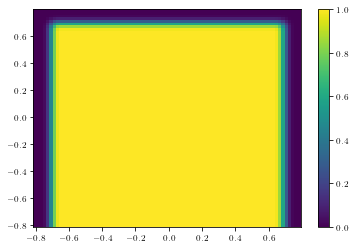

In [12]:
P.figure(1, facecolor='w')
P.pcolormesh(eta_grid,xi_grid,sigma_b)
P.colorbar()

In [13]:
def BC_E_metal_a():
    
    for i in range(0, NG + 1):        
        Er_a[i, :] = 0.0
        E2u_a[i, :] = 0.0
    for i in range(0, NG):        
        E1u_a[i, :] = 0.0

    for j in range(0, NG + 1):
        Er_a[:, j] = 0.0
        E1u_a[:, j] = 0.0
    for j in range(0, NG):        
        E2u_a[:, j] = 0.0

    for j in range(Neta + NG, Neta + 2 * NG):
        Er_a[:, j] = 0.0
        E1u_a[:, j] = 0.0
        E2u_a[:, j] = 0.0

def BC_B_metal_a():
    
    for i in range(0, NG + 1):   
        B1u_a[i, :] = 0.0
    for i in range(0, NG):
        Br_a[i, :] = 0.0
        B2u_a[i, :] = 0.0
        
    for j in range(0, NG + 1):
        B2u_a[:, j] = 0.0
    for j in range(0, NG):
        Br_a[:, j] = 0.0
        B1u_a[:, j] = 0.0
        
    for j in range(Neta + NG, Neta + 2 * NG):
        B2u_a[:, j] = 0.0
        Br_a[:, j] = 0.0
        B1u_a[:, j] = 0.0

def BC_E_metal_b():
        
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Er_b[i, :] = 0.0
        E2u_b[i, :] = 0.0
        E1u_b[i, :] = 0.0

    for j in range(0, NG + 1):
        Er_b[:, j] = 0.0
        E1u_b[:, j] = 0.0
    for j in range(0, NG):        
        E2u_b[:, j] = 0.0

    for j in range(Neta + NG, Neta + 2 * NG):
        Er_b[:, j] = 0.0
        E1u_b[:, j] = 0.0
        E2u_b[:, j] = 0.0

def BC_B_metal_b():
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        B1u_b[i, :] = 0.0
        Br_b[i, :] = 0.0
        B2u_b[i, :] = 0.0
        
    for j in range(0, NG + 1):
        B2u_b[:, j] = 0.0
    for j in range(0, NG):
        Br_b[:, j] = 0.0
        B1u_b[:, j] = 0.0
        
    for j in range(Neta + NG, Neta + 2 * NG):
        B2u_b[:, j] = 0.0
        Br_b[:, j] = 0.0
        B1u_b[:, j] = 0.0

In [14]:
# Initial conditions

theta0, phi0 = 90.0 / 360.0 * 2.0 * N.pi, 120.0 / 360.0 * 2.0 * N.pi # Center of the wave packet
w = 0.1 # Radius of wave packet
amp = 0.2 # Maximal amplitude
wave = 1.0
J0 = 2.0
B0 = 0.0

def shape_packet(x, y, z, width):
    return amp * N.exp(- y * y / (width * width)) * N.exp(- x * x / (width * width)) * N.exp(- z * z / (width * width)) 

def initialize_sim():
    
    for i in range(Nxi + 2 * NG):
        for j in range(Neta + 2 * NG):
            
            X = N.tan(xi[i])
            Y = N.tan(eta[j])

            theta = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))
            phi = N.arctan2(1.0 / N.sqrt(1.0 + X * X), X / N.sqrt(1.0 + X * X))

            x = N.sin(theta) * N.cos(phi)
            y = N.sin(theta) * N.sin(phi)
            z = N.cos(theta)
            
            x0 = N.sin(theta0) * N.cos(phi0)
            y0 = N.sin(theta0) * N.sin(phi0)
            z0 = N.cos(theta0)
            
            Br_a[i,j]  = 0.0 # shape_packet(x - x0, y - y0, z - z0, w) # * N.cos(2.0 * N.pi * eta[j] / wave)
            E2u_a[i,j] = 0.0 # - shape_packet(x - x0, y - y0, z - z0, w) # * N.sin(2.0 * N.pi * eta[j] / wave)
            B1u_a[i,j] = 0.0
            Er_a[i,j]  = 0.0 # shape_packet(x - x0, y - y0, z - z0, w) 
            E1u_a[i,j] = 0.0
            B2u_a[i,j] = 0.0
            
            Br_b[i,j]  = 0.0
            E2u_b[i,j] = 0.0
            B1u_b[i,j] = 0.0
            Er_b[i,j]  = 0.0 # shape_packet(x - x0, y - y0, z - z0, w) 
            E1u_b[i,j] = 0.0
            B2u_b[i,j] = 0.0

            B1d_a[i,j] = 0.0
            B2d_a[i,j] = 0.0
            E1d_a[i,j] = 0.0
            E2d_a[i,j] = 0.0
            
            B1d_b[i,j] = 0.0
            B2d_b[i,j] = 0.0
            E1d_b[i,j] = 0.0
            E2d_b[i,j] = 0.0


In [15]:
theta0, phi0 = 90.0 / 360.0 * 2.0 * N.pi, 60.0 / 360.0 * 2.0 * N.pi # Center of the wave packet

def Jr_a(it, xi, eta):
    
    X = N.tan(xi)
    Y = N.tan(eta)

    theta = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))
    phi = N.arctan2(1.0 / N.sqrt(1.0 + X * X), X / N.sqrt(1.0 + X * X))

    x = N.sin(theta) * N.cos(phi)
    y = N.sin(theta) * N.sin(phi)
    z = N.cos(theta)
        
    x0 = N.sin(theta0) * N.cos(phi0)
    y0 = N.sin(theta0) * N.sin(phi0)
    z0 = N.cos(theta0)
        
    return J0 * N.sin(20.0 * dt * it) * shape_packet(x - x0, y - y0, z - z0, w) #shape_packet(xi[i], eta[j], 0.0, w)

def Jr_b(it, xi, eta):
   
    X = N.tan(xi)
    Y = N.tan(eta)

    theta = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))
    phi = N.arctan2(1.0 / N.sqrt(1.0 + X * X), X / N.sqrt(1.0 + X * X))

    x = N.sin(theta) * N.cos(phi)
    y = N.sin(theta) * N.sin(phi)
    z = N.cos(theta)
        
    x0 = N.sin(theta0) * N.cos(phi0)
    y0 = N.sin(theta0) * N.sin(phi0)
    z0 = N.cos(theta0)
        
    return 0.0 # J0 * N.sin(20.0 * dt * it) * shape_packet(x - x0, y - y0, z - z0, w) #shape_packet(xi[i], eta[j], 0.0, w)


Plot fields in $(\xi, \eta)$ coordinates

In [16]:
xi_tot = N.concatenate((xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)]), axis = 1)
eta_tot = N.concatenate((eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)] + N.pi / 2.0), axis = 1)
    
fig = P.figure(1, facecolor = 'w')

def plot_fields_plane(it, field):
    
    field_a = (globals()[field + "_a"])
    field_b = (globals()[field + "_b"])
    
    fig_size = deffigsize(2.0,0.7)
    ratio = 1.0
    
    vm = 0.2 * amp
    
    ax  = P.subplot(121)
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], field_a[NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.set_xlabel(r"$\xi_a$")
    ax.set_ylabel(r"$\eta$")
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
        
    ax  = P.subplot(122)
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    f = ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], field_b[NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.set_xlabel(r"$\xi_b$")
    ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none') 
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
        
    P.subplots_adjust(wspace = 0, hspace=0)

    figsave_png("snapshots/" + field + "_" + str(it))
    
    # P.close("all")

<Figure size 432x288 with 0 Axes>

Plot divergence of B

In [17]:
eta_grid_tot, xi_grid_tot = N.meshgrid(eta, N.arange(2 * Nxi + 2 * NG) * dxi * 4.0 / N.pi - 1.0)

def plot_divB(it, fig, ax, vm, ratio):
    
    ax  = P.subplot(111)
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    f = ax.pcolormesh(xi_grid_tot, eta_grid_tot, divB, cmap = "Spectral_r", vmax = vm, vmin = - vm)
    ax.set_xlabel(r"$\xi_a$")
    ax.set_ylabel(r"$\eta$")
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    ax.plot([4.0 * xi[Nxi + NG] / N.pi, 4.0 * xi[Nxi + NG] / N.pi], [eta[0], eta[-1]], color='k', ls = '--', lw = 1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=fig.colorbar(f,cax=cax)
    cbar.ax.tick_params(labelsize=9)
    cbar.ax.minorticks_off()

    figsave_png(fig, "snapshots/divB_" + str(it))

In [18]:
def plot_interp_profile(it, fig, ax, fdump):
    
    j0 = int(Neta / 2) + 10

    ax.cla()
    ax.plot(xi[:(Nxi + NG)], Er_a[:(Nxi + NG), j0], color='k', label = r"$E^r$")
    ax.plot(xi[NG:] + N.pi/2.0, Er_b[(NG):, j0], color='k')

    ax.plot(xi[:(Nxi + NG)], B1u_a[:(Nxi + NG), j0], color=colours[1], label = r"$B^\xi$")
    ax.plot(xi[NG:] + N.pi/2.0, B1u_b[(NG):, j0], color=colours[1])

    ax.plot(xi[:(Nxi + NG)], B2u_a[:(Nxi + NG), j0], color=colours[0], label = r"$B^\eta$")
    ax.plot(xi[NG:] + N.pi/2.0, B2u_b[(NG):, j0], color=colours[0])

    ax.plot([xi[Nxi + NG], xi[Nxi + NG]], [eta[0], eta[-1]], color='k', ls = '--', lw = 1)

    ax.set_xlim(N.pi / 4.0 - 0.4, N.pi / 4.0 + 0.4)
    ax.set_ylim(- N.pi / 4.0, N.pi / 4.0)
    ax.set_xlabel(r"$\xi$")
    ax.set_ylabel(r"$\eta$")
    
    P.title(r"$t = {}$".format(it * fdump))
    
    P.legend(loc = 'upper right')
    
    figsave_png(fig, "snapshots/profile_" + str(it))

Project fields on a sphere, with spherical $(\theta, \varphi)$ coordinates

In [19]:
phi_a = xi_grid
theta_a = 0.5 * N.pi - N.arctan(N.tan(eta_grid) * N.cos(phi_a))

phi_b = 0.5 * N.pi + xi_grid
theta_b = 0.5 * N.pi - N.arctan(N.tan(eta_grid) * N.sin(phi_b))

x_a = r * N.sin(theta_a) * N.cos(phi_a)
y_a = r * N.sin(theta_a) * N.sin(phi_a)
z_a = r * N.cos(theta_a)

x_b = r * N.sin(theta_b) * N.cos(phi_b)
y_b = r * N.sin(theta_b) * N.sin(phi_b)
z_b = r * N.cos(theta_b)

phi_s = N.linspace(0, N.pi, 2*50)
theta_s = N.linspace(0, 2*N.pi, 2*50)
theta_s, phi_s = N.meshgrid(theta_s, phi_s)
x_s = 0.99 * N.sin(phi_s) * N.cos(theta_s)
y_s = 0.99 * N.sin(phi_s) * N.sin(theta_s)
z_s = 0.99 * N.cos(phi_s)

cmap_plot="RdBu_r"
norm_plot = matplotlib.colors.Normalize(vmin = - amp, vmax = amp)
m = matplotlib.cm.ScalarMappable(cmap = cmap_plot, norm = norm_plot)
m.set_array([])

# Function to update axes
def plot_fields_sphere(it, field, fig, ax, res):
    
    field_a = (globals()[field + "_a"])
    field_b = (globals()[field + "_b"])
    fcolors_a = m.to_rgba(field_a[NG:(Nxi + NG),NG:(Neta + NG)])
    fcolors_b = m.to_rgba(field_b[NG:(Nxi + NG),NG:(Neta + NG)])
    
    ax.plot_surface(x_s, y_s, z_s, rstride=1, cstride=1, shade=False, color = 'grey', zorder = 0)
    
    sf_a = ax.plot_surface(x_a[NG:(Nxi + NG),NG:(Neta + NG)], y_a[NG:(Nxi + NG),NG:(Neta + NG)], \
               z_a[NG:(Nxi + NG),NG:(Neta + NG)], \
               rstride = res, cstride = res, shade = False, \
               facecolors = fcolors_a, norm = norm_plot, zorder = 1)

    sf_b = ax.plot_surface(x_b[NG:(Nxi + NG),NG:(Neta + NG)], y_b[NG:(Nxi + NG),NG:(Neta + NG)], \
               z_b[NG:(Nxi + NG),NG:(Neta + NG)], \
               rstride = res, cstride = res, shade = False, \
               facecolors = fcolors_b, norm = norm_plot,zorder = 1)
    
    contours_a = find_contours(Ar, 0.001)
    contours_b = find_contours(Ar, -0.001)
    contours = contours_a + contours_b
    if (len(contours) > 0):
        for ind in range(len(contours)):
            xy = contours[ind]
            xi_c, eta_c = xy.T

            phi_c = xi_c * dxi + xi[0]
            theta_c = 0.5 * N.pi - N.arctan(N.tan(eta_c * deta + eta[0]) * N.cos(phi_c))
            x_c = r * N.sin(theta_c) * N.cos(phi_c)
            y_c = r * N.sin(theta_c) * N.sin(phi_c)
            z_c = r * N.cos(theta_c)
            
            lines = ax.plot(x_c, y_c, z_c, color = 'black', zorder = 10)

    figsave_png(fig, "snapshots/" + field + "_" + str(it))
    
    # sf_a.remove()
    # sf_b.remove()
    # if (len(contours) > 0):
    #     lines.pop(0).remove()
    
    ax.cla()

In [20]:
# Initialize simulation
initialize_sim()
iter = 0
idump = 0

# # Clean memory
# del(Er0_a)
# del(E1u0_a)
# del(E2u0_a)
# del(Br0_a)
# del(B1u0_a)
# del(B2u0_a)
# del(Er0_b)
# del(E1u0_b)
# del(E2u0_b)
# del(Br0_b)
# del(B1u0_b)
# del(B2u0_b)

# gc.collect()

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

176

177

178

179

180

181

182

183

184

185

186

187

188

189

190

191

192

193

194

195

196

197

198

199

200

201

202

203

204

205

206

207

208

209

210

211

212

213

214

215

216

217

218

219

220

221



KeyboardInterrupt: 

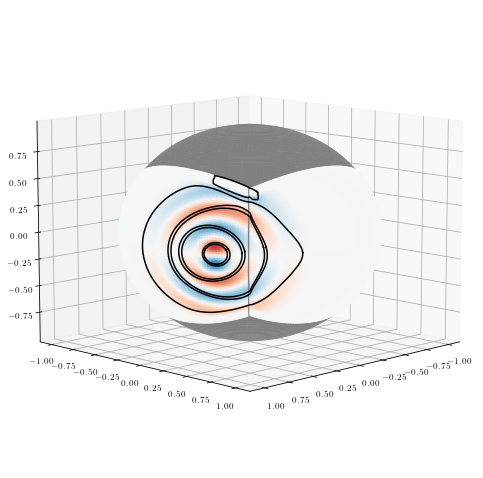

In [21]:
Nt = 1500 # Number of iterations
FDUMP = 10 # Dump frequency

# Figure parameters
scale, aspect = 2.0, 0.7
vm = 0.2 * amp
ratio = 0.5

# Define figure
fig_size=deffigsize(scale, aspect)
fig, ax = P.subplots(subplot_kw={"projection": "3d"}, figsize = fig_size, facecolor = 'w')
ax.view_init(elev=10, azim=45)
ax.plot_surface(x_s, y_s, z_s, rstride=1, cstride=1, shade=False, color = 'grey')

# fig_size=deffigsize(scale, aspect)
# fig = P.figure(1, facecolor='w')
# ax = P.subplot(111)

# Run the simulation
for it in range(Nt):
    if ((it % FDUMP) == 0):
        # compute_div_B()
        # plot_divB(idump, fig, ax, 1e-2, 0.5)
        plot_fields_sphere(idump, "B1u", fig, ax, 1)
        # plot_interp_profile(idump, fig, ax, FDUMP)
        idump += 1

    print(it)
    iter += 1
    
    contra_to_cov_E_a()
    contra_to_cov_E_b()
    
    contra_to_cov_E_edge_a()
    contra_to_cov_E_edge_b()
    
    compute_Eu_edge()
    compute_Ed_edge() 
    
    push_B_a()
    push_B_edge_a()
    push_B_b()
    
    BC_B_metal_a()
    BC_B_absorb_a()
    BC_B_metal_b()
    BC_B_absorb_b()

    contra_to_cov_B_a()
    contra_to_cov_B_b()
    
    contra_to_cov_B_edge_a()
    contra_to_cov_B_edge_b()

    compute_Bu_edge()
    compute_Bd_edge()    

    push_E_a(it)
    push_E_edge_b()
    push_E_b(it)
    
    BC_E_metal_a()
    BC_E_absorb_a()
    BC_E_metal_b()
    BC_E_absorb_b()

    compute_potential()

P.close('all')


In [ ]:
fig_size=deffigsize(scale, aspect)

fig = P.figure(1, facecolor='w', figsize = fig_size)

j0 = int(Neta / 2)

P.plot(xi[:(Nxi + NG)], Er_a[:(Nxi + NG), j0], color='k')
P.plot(xi[NG:] + N.pi/2.0, Er_b[(NG):, j0], color='k')

P.plot(xi[:(Nxi + NG)], B1u_a[:(Nxi + NG), j0], color=colours[1], ls = styles[1])
P.plot(xi[NG:] + N.pi/2.0, B1u_b[(NG):, j0], color=colours[1], ls = styles[1])

P.plot(xi[:(Nxi + NG)], B2u_a[:(Nxi + NG), j0], color=colours[0], ls = styles[2])
P.plot(xi[NG:] + N.pi/2.0, B2u_b[(NG):, j0], color=colours[0], ls = styles[2])

P.xlim(N.pi/4.0 - 0.2, N.pi/4.0 + 0.2)